# Tutorial notebook for hera_pspec

This notebook is intended as a tutorial for all basic features of the hera_pspec package.
It includes examples of
* How to compute a [delay power spectrum](#sec:delay) for different options including the choice of the input data weights, the spectral range considered (following data flagging)
* How to convert this power spectrum in [cosmological units](#subsec:delay_cosmo)
* How to obtain [error bars](#sec:other) on the power spectrum, from [thermal noise](#subsec:other_thermal_noise) and from the [output covariance](#subsec:other_data_errors)
* How to extract the [window functions](#subsec:other_wf) and output covariance 
* How to make a [wedge plot](#subsec:delay_wedge)
* How to perform [coherent and incoherent time- and redundant-averages](#sec:averages), as well as how to construct [redundant baseline groups](#subsec:average_groups)
    
The structure is as follows:
1. In [Sec. 1](#data_description), we extract useful information from the data file, such as the frequency range covered, or the list of redundant basiles. We also use a beam file for converstions into cosmological units.
2. In [Sec. 2](#sec:delay), we calculate the (incoherently) time- and redundant baseline-averaged delay spectrum (a) for a single redundant baseline group, (b) in the presence of flags that are separable in time and frequency, (c) excluding auto-baselines, and (d) with identity weighting
    * [Computing the delay spectrum](#subsec:delay_spectrum)
    * [Converting to cosmological units](#subsec:delay_cosmo)
    * [Making a wedge plot](#subsec:delay_wedge)
3. In [Sec. 3](#sec:averages), we compare power spectra and wedge plots obtained with coherent and incoherent averaging, that is if the data is averaged over time and/or redudancy before or after computing the power spectrum.
    * [Building redundant groups](#subsec:average_groups)
    * [Incoherent average](#subsec:average_incoherent)
    * [Coherent average](#subsec:average_coherent)
    * [Comparison](#subsec:average_comparison) of power spectra and wedge plots

We also provide an alternative method to perform the coherent/incoherent averaging comparison [here](#subsec:average_alternative).

4.  In [Sec. 4](#sec:other), we present different elements related to error bars on the resulting power spectrum, that is:
    * Obtaining vertical error bars stemming from [thermal noise](#subsec:other_thermal_noise)
    * Obtaining vertical error bars from the [data covariance](#subsec:other_data_errors) matrix
    * Obtaining horizontal error bars with the [window functions](#subsec:other_wf)

This notebook was the result of a code review performed by Hugh Garsden and Adélie Gorce between January and June 2021. It might need to be updated once new features have been added to the module.

---

## Data description 

Import Python packages, set cosmology, beam, pol, data sets.
<a id='data_description'></a>

In [1]:
from pyuvdata import UVData, UVFlag
import hera_pspec as hp
import hera_qm as hq
import numpy as np
from astropy import units
import matplotlib.pyplot as plt
import copy, os, itertools, inspect
from hera_pspec.data import DATA_PATH
from pyuvdata import utils as uvutils
colorlist = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c','#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5','#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f','#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#### cosmology
cosmo = hp.conversions.Cosmo_Conversions()

Import data

In [3]:
# select the data file to load
dfile = os.path.join(DATA_PATH, 'sim4.uvh5')
# Load into UVData objects
uvd = UVData()
uvd.read(dfile)

Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array. Largest imaginary component was 3.1219314517741434e-15, largest imaginary/real ratio was 2.4923919118372765e-18.


In [4]:
print(f'{uvd.freq_array.size} frequency channels ranging from {uvd.freq_array[0]/1e6:.1f} '
      f'to {uvd.freq_array[-1]/1e6:.1f} MHz with channel width {uvd.channel_width.mean()/1e3:.1f} kHz')
print(f'{len(uvd.get_redundancies()[0])} redundant groups')

60 frequency channels ranging from 100.0 to 119.7 MHz with channel width 333.3 kHz
51 redundant groups


It is also possible to list all available baselines with `uvd.get_antpairs()`, but we do not do it here as the list is  too long.

In [ ]:
#########################
##### POLARISATION ######
#########################

print(f'Available polarisation: {uvd.get_pols()}')
pol = 'xx'
print(f'Considering polarisation {pol}')

Available polarisation: ['ee']
Considering polarisation xx


Extract beam information

In [6]:
##################
###### BEAM ######
##################

# List of beamfile to load. This is a healpix map.
beamfile = os.path.join(DATA_PATH, 'HERA_NF_dipole_power.beamfits')
# instantiate beam and pass cosmology, if not fed, a default Planck cosmology will be assumed
uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)
# find conversion factor from Jy to mK
Jy_to_mK = uvb.Jy_to_mK(uvd.freq_array, pol=pol)

# reshape to appropriately match a UVData.data_array object and multiply in!
uvd.data_array *= Jy_to_mK[None, :, None]

In [7]:
###### CHOOSE DATA TO USE

# slide the time axis of uvd by one integration
uvd1 = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False)
uvd2 = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False)

# Create a new PSpecData object, and don't forget to feed the beam object
ds = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=uvb)

# here we phase all datasets in dsets to the zeroth dataset
ds.rephase_to_dset(0)

# change units of UVData objects
ds.dsets[0].vis_units = 'mK'
ds.dsets[1].vis_units = 'mK'

# Delay spectrum calculation and averaging
<a id='sec:delay'></a>

In this section, we calculate the (incoherently) time- and redundant baseline-averaged delay spectrum (a) for a single redundant baseline group, (b) in the presence of flags that are separable in time and frequency, (c) excluding auto-baselines, and (d) with identity weighting

## Delay spectrum
<a id='subsec:delay_spectrum'></a>

### (a) Choose redundant baseline group

In [ ]:
###############################
#### REDUNDANT BASELINES ######
###############################

# sort baselines in redundant groups
baseline_group, _, lengths = uvd.get_redundancies()

#convert baseline number to antenna numbers tuple
blp_group = []
for group in baseline_group:
    g = []
    g.extend(uvd.baseline_to_antnums(bl) for bl in group)
    blp_group.append(g)

# choose one redundancy group for which to compute the power spectrum
baselines = blp_group[1] #first group is auto baselines
print(f'Baselines considered: {baselines}.')
print('They have length %.1f m.' %lengths[1])


Baselines considered: [(0, 1), (1, 2), (3, 4), (4, 5), (5, 6), (7, 8), (8, 9), (9, 10), (10, 11), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (18, 19), (19, 20), (20, 21), (21, 22), (23, 24), (24, 25), (25, 26), (27, 28), (28, 29)].
They have length 14.6 m.


### (b) Find unflagged spectral ranges 

The data file used here is a simulation, and therefore does not include flags, which would normally indicate which data points are spoilt - for example, by RFI, and should not be used. 
As an example, here, we artificially add flags.

In [9]:
uvd.flag_array[:, :9] = True
uvd.flag_array[:, 50:53] = True

We choose the spectral range among data flagged as True ('good data').

In [10]:
spw_range = (10,49)
freq_range = [uvd.freq_array[i]/1e6 for i in spw_range]
print('Frequencies considered range from %.1f to %.1f MHz' %(freq_range[0],freq_range[1]))

Frequencies considered range from 103.3 to 116.3 MHz


This is illustrated in the figure below, where blue regions are False flags, yellow True flags and the hatched region corresponds to the spectral range considered.

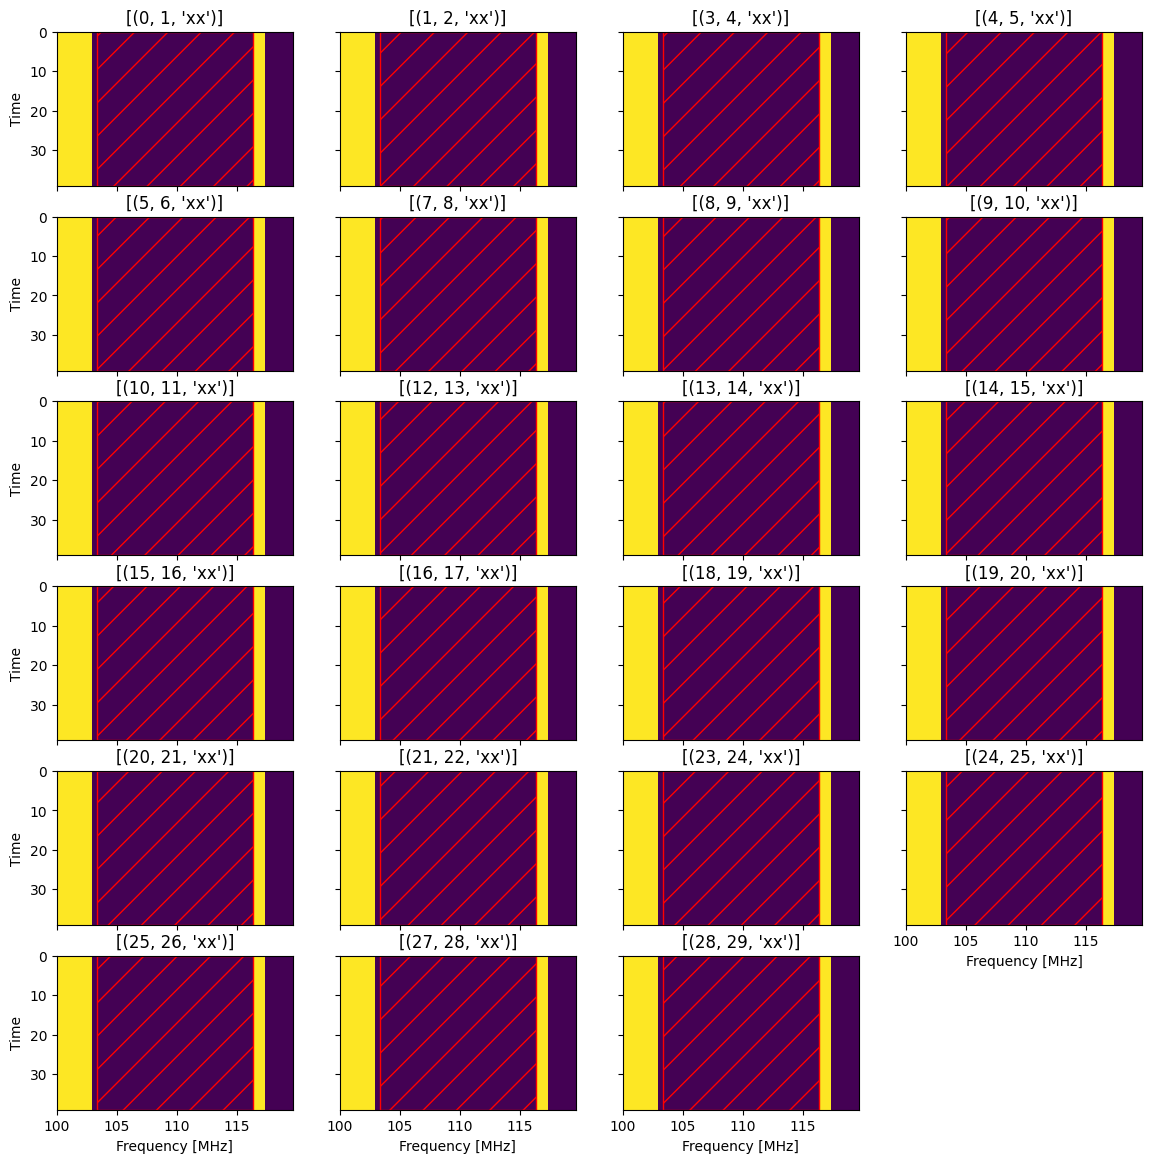

In [11]:
###################
###### FLAGS ######
###################

fig, axes = plt.subplots(6,4,figsize=(14,14))
u=0
for i,bl in enumerate(baselines):
    if (u>3):
        u=0
    il = i//4
    ic = u
    ax = axes[il,ic]
    
    key = [(bl[0],bl[1],pol)]
    ax.imshow(uvd.get_flags(key),aspect='auto',extent=(uvd.freq_array[0]/1e6,uvd.freq_array[-1]/1e6,uvd.Ntimes-1,0))
    ax.axvspan(freq_range[0],freq_range[1],fill=False,color='red',hatch='/')

    if (il==5) or ((il==4 and u==3)):
        ax.set_xlabel('Frequency [MHz]')
    else:
        ax.set_xticklabels([])
    if (ic==0):
        ax.set_ylabel('Time')
    else: 
        ax.set_yticklabels([])
    ax.set_title(key)
    
    u=u+1
axes[-1,-1].set_visible(False)


The spectral range we choose to consider is shown as a red region on the above figure.

### (c) Construct baseline pairs, excluding auto-baselines

We construct pairs of baselines to correlate when constructing the power spectrum. Here, the baselines cross-correlated belong to the same redundant group.

In [12]:
# construct all baseline pairs from group
baselines1, baselines2, blpairs = hp.utils.construct_blpairs(baselines,exclude_permutations=True,
                                                            exclude_auto_bls=True)

### (d) Compute power spectrum for identity weighting of data

In [13]:
uvp = ds.pspec(baselines1, baselines2, dsets=(0, 1), pols=[(pol, pol)], spw_ranges=[spw_range], verbose=False,
              input_data_weight='identity')

Casting complex values to real discards the imaginary part


In [14]:
uvp.data_array[0].shape, uvp.Ntimes, uvp.Nblpairs, uvp.Nfreqs

((5060, 39, 1), 40, 253, 39)

We plot the resulting delay power spectrum as a function of the delay, for only one of the considered baseline pairs, for all measurements. Note that, because the baselines considered are redundant, the delay power spectra obtained for the different baseline pairs are very similar.

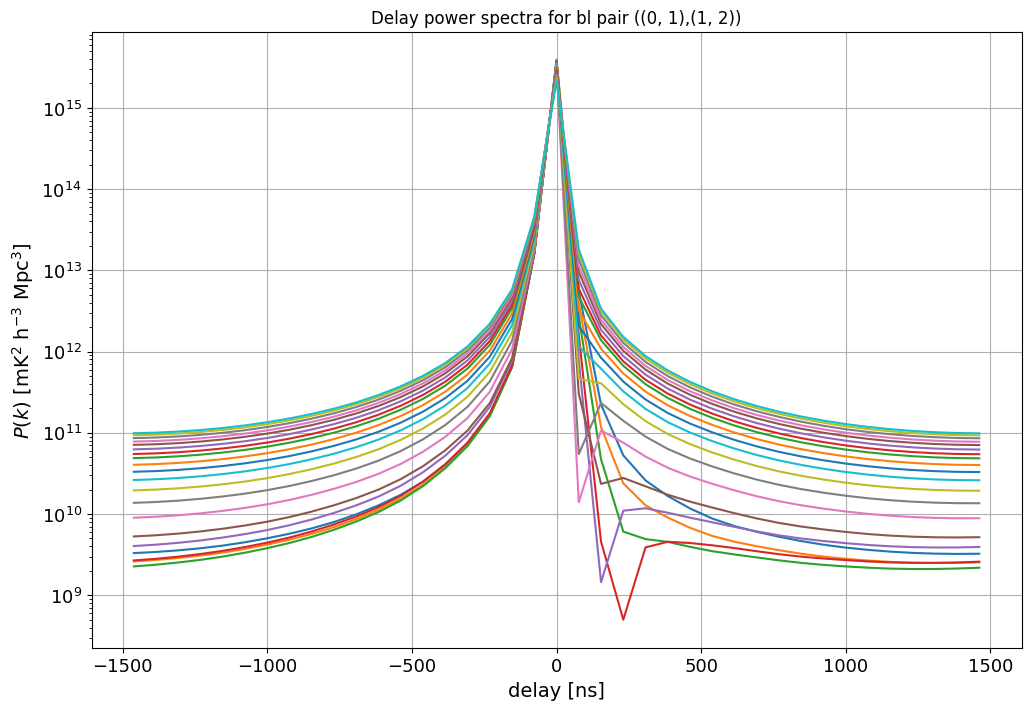

In [15]:
# plot results
spw = 0
dlys = uvp.get_dlys(spw)*1e9 #ns
fig, ax = plt.subplots(figsize=(12,8))
blp  = blpairs[0]
key = (spw, blp, pol)
power = np.abs(np.real(uvp.get_data(key)))
_ = ax.semilogy(dlys, power.T)
ax.grid()
ax.set_xlabel("delay [ns]", fontsize=14); ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.set_title(r'Delay power spectra for bl pair (%s,%s)' %blp)
ax.tick_params(labelsize=13)

It is also possible to directly use a `hera_pspec` function:

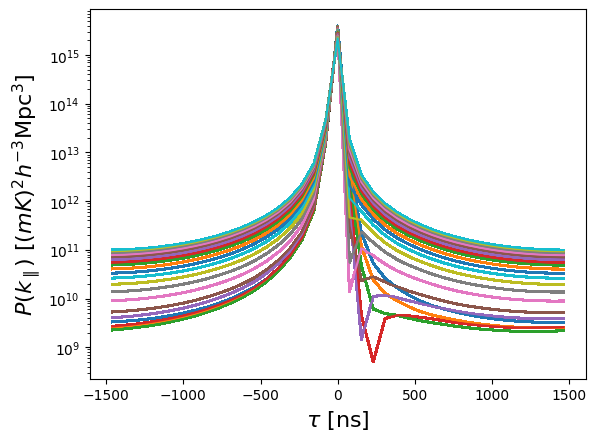

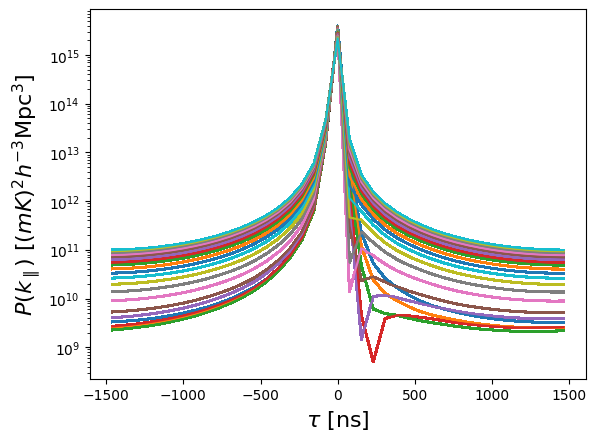

In [16]:
hp.plot.delay_spectrum(uvp, blpairs, spw, pol,force_plot=True)

If there is more than one time of measurement, there will be as many delay spectra in the output `PSpec` object. Here, we plot the delay spectrum for each time, as well as the time-averaged spectrum.

In [17]:
# time-average the power spectrum for this group
uvp2 = uvp.average_spectra(time_avg=True, inplace=False)

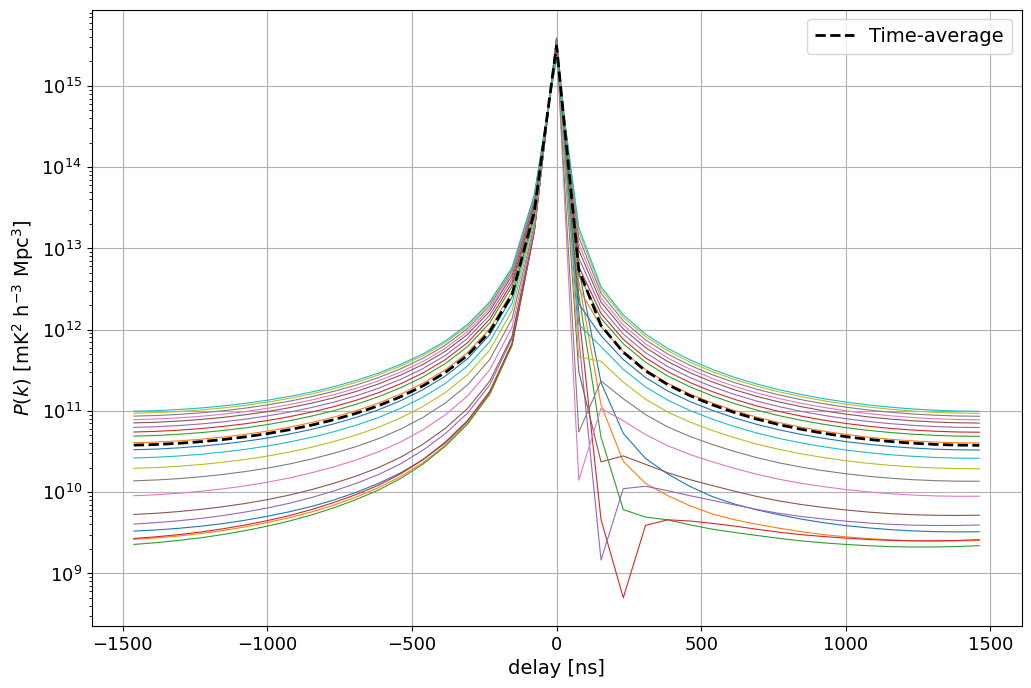

In [18]:
# plot results for one baseline
blp = blpairs[4]
spw = 0
key = (spw, blp, pol)
power = np.abs(np.real(uvp.get_data(key)))
ps_avg_ints = np.abs(np.real(uvp2.get_data((spw, blp, pol)))).flatten()

fig, ax = plt.subplots(figsize=(12,8))
_ = ax.plot(dlys, power.T,lw=.8)
ax.plot(dlys,ps_avg_ints,color='k',lw=2,label='Time-average',ls='--')
ax.set_yscale('log')
ax.grid()
ax.legend(fontsize=14)
ax.set_xlabel("delay [ns]", fontsize=14)
ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.tick_params(labelsize=13)

## Cosmological power spectrum
<a id='subsec:delay_cosmo'></a>

In this section, we take the spherical average in $k$ of the delay power spectrum computed above, with correct cosmological units and normalisation.

In [19]:
dsq = copy.deepcopy(uvp2) # make a copy of the UVPSpec object
dsq.convert_to_deltasq() # convert to dimless power spectrum

In [20]:
# k_parallel and k_perp
k_perp, k_para = dsq.get_kperps(spw, little_h=True), dsq.get_kparas(spw, little_h=True)
blpt_inds = dsq.blpair_to_indices(dsq.get_blpairs()[0])#redundant baseline group: unique k_perp
k_arr = np.sqrt(k_perp[blpt_inds][0]**2 + k_para**2)

In [21]:
# binning in k for spherical average
dk = 0.05
kbins = np.arange(0.005, 0.7, dk)

In [22]:
# spherical average the time-averaged spectrum
uvp3 = hp.grouping.spherical_average(dsq,kbins,bin_widths=dk)

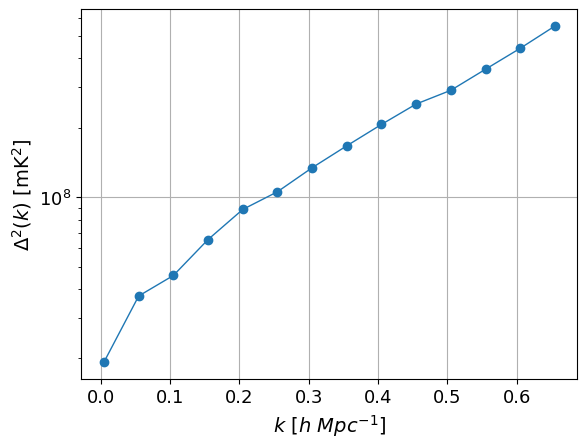

In [23]:
blp = blpairs[0]
ps = np.abs(np.real(uvp3.get_data((spw, blp, pol)))).flatten()

fig, ax = plt.subplots()
ax.errorbar(kbins,ps,marker='o',lw=1.,elinewidth=1.)
ax.set_yscale('log')
ax.grid()
ax.set_xlabel(r"$k\ [h\ Mpc^{-1}]$", fontsize=14)
ax.set_ylabel(r"$\Delta^2(k)\ \rm [mK^2]$", fontsize=14)
ax.tick_params(labelsize=13)

## Wedge plot
<a id='subsec:delay_wedge'></a>

In this section, we show how to make a wedge plot, often used to identify where the bulk of the foregrounds is located in the data.

We first perform a redundant average (see next section):

In [24]:
# get redundant groups
groups, _, _ = uvd.get_redundancies(include_autos=False)

In [25]:
# construct baseline pairs within redundant groups
# convert to antenna number tuples
baselines1, baselines2 = [], []
bl_groups, bl_pairs = [], []
for group in groups:
    antpairs = [uvd.baseline_to_antnums(j) for j in group]
    bl_groups.append(antpairs)
    bls1, bls2, blpairs = hp.utils.construct_blpairs(antpairs,exclude_permutations=True,exclude_auto_bls=True)
    if len(blpairs)>0:
        bl_pairs.append(blpairs)
    baselines1 += bls1
    baselines2 += bls2

Note that we could use the `hp.utils.calc_blpair_reds` function but we choose the above method as it allows us to output the grouped baseline pairs, later used when averaging the spectrum. The function also does not consider zero-baselines (ex: (24,24)).

In [26]:
b1, b2, bp, _, _ = hp.utils.calc_blpair_reds(uvd,uvd, exclude_auto_bls=True)

In [27]:
# construct PS from all available baselines, cross-correlating them even if not redundant
uvp = ds.pspec(baselines1, baselines2, dsets=(0, 1), pols=[(pol, pol)], spw_ranges=[spw_range], verbose=False)

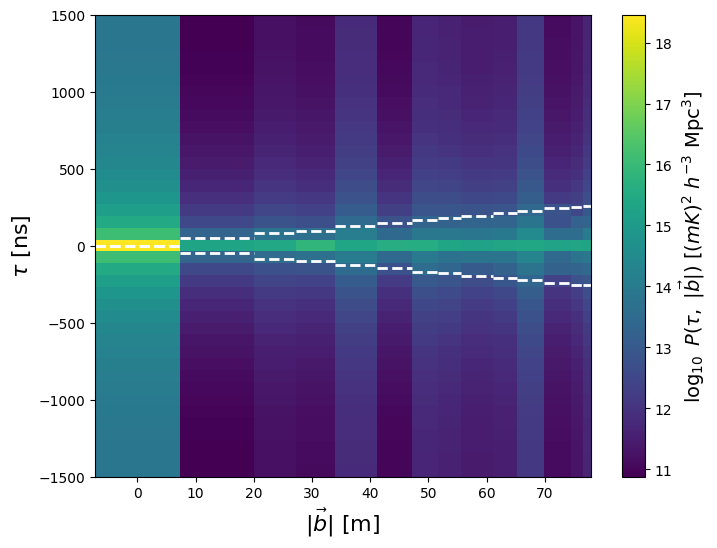

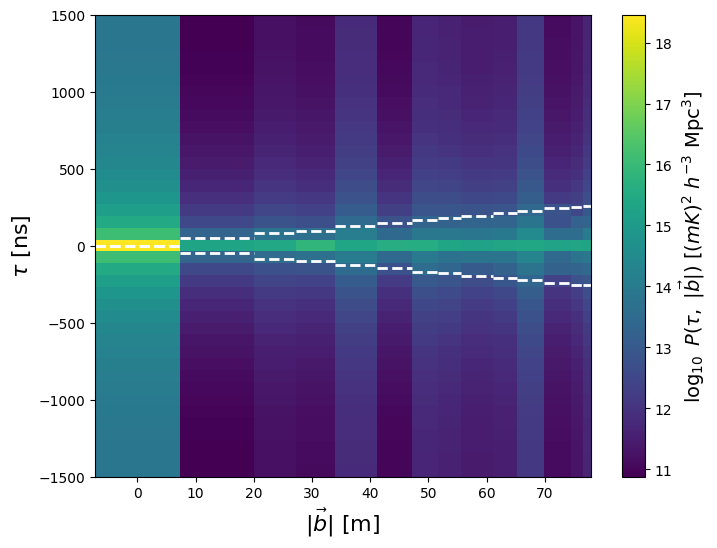

In [28]:
hp.plot.delay_wedge(uvp,spw,(pol,pol),ax=None,delay=True, rotate=True, horizon_lines=True, colorbar=True)

# Coherently and incoherently averaged spectra
<a id='sec:averages'></a>

There are different ways of averaging the data. It is possible to average over redundant baselines (that is a **redundant average**) or over time (that is a **time average**). If the average is performed before computing the power spectrum, it is called a **coherent average**. If it is performed after squaring the data and computing the power spectra (see above), it is an **incoherent average**. 
In this section, we compare the power spectra and wedge plots resulting from these two averaging methods.

## Redundant groups
<a id='subsec:average_groups'></a>

We start by grouping the different baselines into redundant groups.

In [29]:
# construct baseline pairs within redundant groups
groups, _, _ = uvd.get_redundancies(include_autos=False)

In [30]:
# construct baseline pairs within redundant groups
# convert to antenna number tuples
baselines1, baselines2, ungrouped_pairs = [], [], []
bls_grouped, grouped_pairs = [], []
for group in groups:
    antpairs = [uvd.baseline_to_antnums(j) for j in group]
    bls_grouped.append(antpairs) #translate bl_grouped to ant numbers (tuples)
    #construct bl pairs within redundancy group (group)
    bls1, bls2, blpairs = hp.utils.construct_blpairs(antpairs,exclude_permutations=True,exclude_auto_bls=False)
    if len(blpairs)>0:
        grouped_pairs.append(blpairs) #group bl pairs
    baselines1 += bls1 #list first element of bl pairs
    baselines2 += bls2 #list second element of bl pairs
    ungrouped_pairs += blpairs #list bl pairs without grouping

In [31]:
grouped_pairs_notuple = [[uvp.antnums_to_blpair(blp) for blp in blpg] for blpg in grouped_pairs]
# print(grouped_pairs_notuple)

These different lists correspond to the same objects, with different syntaxes corresponding to the inputs required by different functions.

A simpler way is to derive the grouped ant pairs directly with a utils function, and then feed it to `average_spectra` directly.

In [32]:
blp_grps, lens, angs, tags = hp.utils.get_blvec_reds(uvp,match_bl_lens=True)

In [33]:
# compute the power spectrum: only redundant baselines are cross-correlated (corresponding to the pairs in ungrouped_pairs)
uvp = ds.pspec(baselines1, baselines2, dsets=(0, 1), pols=[(pol, pol)], spw_ranges=[spw_range], verbose=False, input_data_weight='identity')

## Incoherent averaging
<a id='subsec:average_incoherent'></a>

Incoherent average is performed *after* computing the individual power spectra.

In [34]:
print(f'There are {uvp.Ntimes} times and {uvp.Nblpairs} baseline pairs in uvp')
print(f'There are {len(groups)} redudant baselines groups and {len(grouped_pairs)} within which we can form antenna pairs')

There are 40 times and 3616 baseline pairs in uvp
There are 51 redudant baselines groups and 51 within which we can form antenna pairs


In [35]:
#no time average, no baseline average
uvp.data_array[0].shape

(72320, 39, 1)

1. Time-average

In [36]:
# time-average the power spectrum with no baseline average
uvp2 = uvp.average_spectra(time_avg=True, inplace=False)
print(uvp2.data_array[0].shape, uvp2.Ntimes)

(3616, 39, 1) 2


The new PSpec object has now 1 time and 63020/20=3151 data entries.

2. Redundant-average

In [37]:
#time-average, redundant average
uvp3 = uvp.average_spectra(blpair_groups = grouped_pairs, time_avg=True, inplace=False)
print(uvp3.data_array[0].shape)

(51, 39, 1)


The new `PSpec` object has as many data entries as redundant groups.

3. Delay spectrum

We will plot the delay spectrum for a specific redundant baseline group within the 51 available.

In [38]:
ii = 12
print(f'{len(grouped_pairs[ii])} baseline bairs in the redundant group chosen (# {ii})')

78 baseline bairs in the redundant group chosen (# 12)


Text(0.5, 0.98, '100112101113')

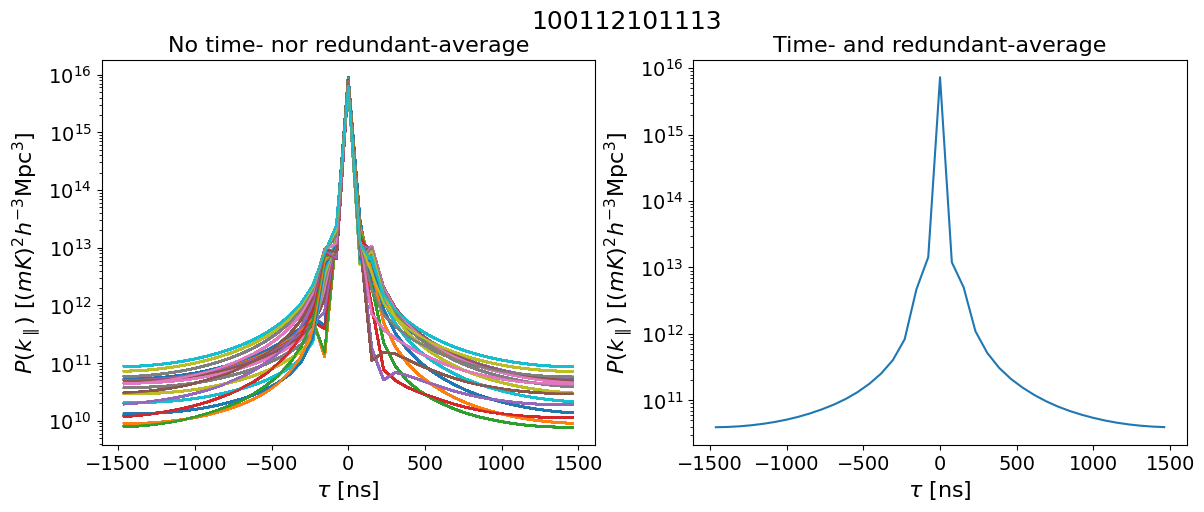

In [39]:
fig,axes= plt.subplots(1,2,figsize=(14,5))
# non-averaged power spectrum
hp.plot.delay_spectrum(uvp, [grouped_pairs[ii]], spw, pol,ax=axes[0])
axes[0].set_title('No time- nor redundant-average',fontsize=16)
axes[0].tick_params(labelsize=14)
# Averaged spectrum
hp.plot.delay_spectrum(uvp3, [uvp3.blpair_array[ii]], spw, pol,ax=axes[1])
axes[1].set_title('Time- and redundant-average',fontsize=16)
axes[1].tick_params(labelsize=14)
fig.suptitle(uvp3.blpair_array[ii],fontsize=18)

4. Wedge plot

Text(0.5, 1.0, 'Time- and redundant-average')

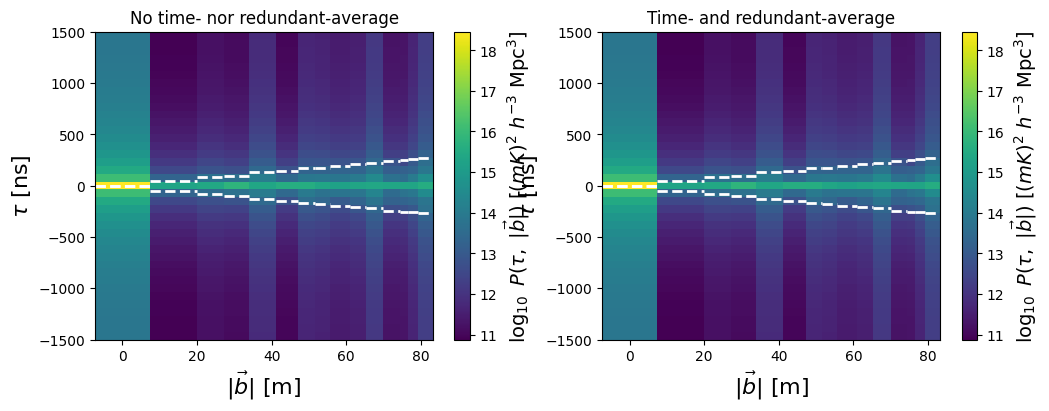

In [40]:
fig,axes= plt.subplots(1,2,figsize=(12,4))
# non-averaged power spectrum
hp.plot.delay_wedge(uvp,spw,(pol,pol),delay=True,ax=axes[0], rotate=True, horizon_lines=True, colorbar=True)
axes[0].set_title('No time- nor redundant-average')
# Averaged spectrum
hp.plot.delay_wedge(uvp3,spw,(pol,pol),delay=True,ax=axes[1], rotate=True, horizon_lines=True, colorbar=True)
axes[1].set_title('Time- and redundant-average')

## Coherent averaging
<a id='subsec:average_coherent'></a>

Coherent average is performed *before* computing the power spectrum. `pyuvdata` includes functions to perform coherent averaging.

1. Redundant baseline-average

In [41]:
# coherent average along redundant groups
groups, _, _ = uvd.get_redundancies(include_autos=False)
uvd_av = uvd.compress_by_redundancy(method='average',inplace=False)
print('Number of baselines before average: %i' %uvd.Nbls)
print('Number of baselines after average: %i'%uvd_av.Nbls)

The use_grid_alg parameter is not set. Defaulting to True to use the new gridding based algorithm (developed by the HERA team) rather than the older clustering based algorithm. This is change to the default, to use the clustering algorithm set use_grid_alg=False.


Number of baselines before average: 465
Number of baselines after average: 51


In [42]:
uvd12 = uvd_av.select(times=np.unique(uvd_av.time_array)[:-1:2], inplace=False)
uvd22 = uvd_av.select(times=np.unique(uvd_av.time_array)[1::2], inplace=False)

2. Time-average

In [43]:
uvd12.downsample_in_time(n_times_to_avg=uvd1.Ntimes)
uvd22.downsample_in_time(n_times_to_avg=uvd1.Ntimes)

Data are unprojected or phased as a driftscan, phasing before resampling.
Undoing phasing.
Data are unprojected or phased as a driftscan, phasing before resampling.
Undoing phasing.


The time difference between integrations is not the same as the integration time for baseline (0, 0). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (0, 1). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (0, 2). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (0, 3). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (0, 4). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (0, 5). The output may average across longer time intervals than e

In [44]:
print('Number of times before average: %i' %uvd1.Ntimes)
print('Number of times after average: %i'%uvd12.Ntimes)

Number of times before average: 20
Number of times after average: 1


3. Power spectrum

In [45]:
ds_av = hp.PSpecData(dsets=[uvd12, uvd22], wgts=[None, None], beam=uvb)
ds_av.rephase_to_dset(0)
ds_av.dsets[0].vis_units = 'mK'
ds_av.dsets[1].vis_units = 'mK'

In [46]:
bls1, bls2, blpairs = hp.utils.construct_blpairs(ds_av.dsets[0].get_antpairs(),
                                                 exclude_cross_bls=True,exclude_auto_bls=False)

In [47]:
uvp_av = ds_av.pspec(bls1, bls2, dsets=(0, 1), pols=[(pol, pol)], spw_ranges=[spw_range], 
                     verbose=False, input_data_weight='identity')

Casting complex values to real discards the imaginary part


## Comparison coherent / incoherent averaging
<a id='subsec:average_comparison'></a>

In [48]:
print(uvp3.Ntimes,uvp3.Nblpairs)
print(uvp_av.Ntimes,uvp_av.Nblpairs)

2 51
2 51


1. Delay spectrum

Text(0.5, 1.0, 'Coherent average')

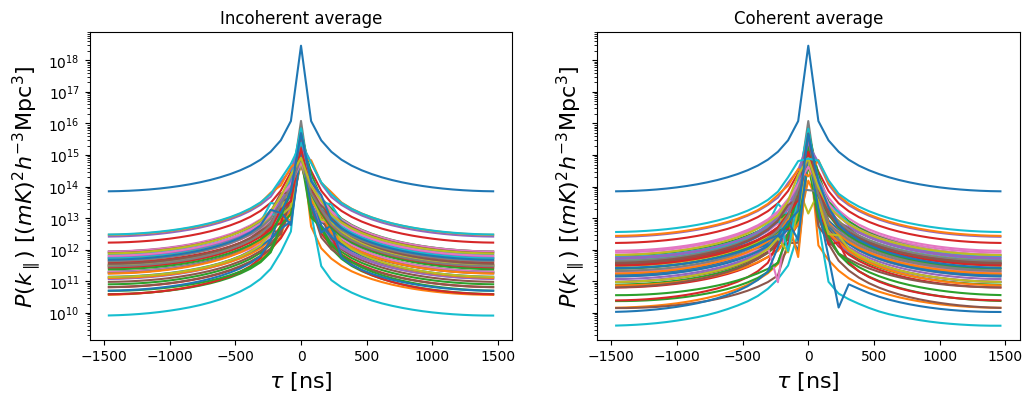

In [49]:
spw = 0

fig,axes= plt.subplots(1,2,figsize=(12,4),sharey=True)
# incoherent average
hp.plot.delay_spectrum(uvp3, uvp3.blpair_array, spw, pol,ax=axes[0], force_plot=True)
axes[0].set_title('Incoherent average')
# Coherent average
hp.plot.delay_spectrum(uvp_av, uvp_av.blpair_array, spw, pol,ax=axes[1], force_plot=True)
axes[1].set_title('Coherent average')

In [50]:
delays = uvp3.get_dlys(spw) * 1e9 #ns

blp1 = (uvd.baseline_to_antnums(uvd.get_redundancies()[0][0][0]),uvd.baseline_to_antnums(uvd.get_redundancies()[0][0][1]))
# blp1 = uvp3.get_blpairs()[0]
incoherent_ps = np.abs(np.real(uvp3.get_data((spw, blp1, pol)))).flatten()

# blp2 = uvp_av.get_blpairs()[0]
blp2 = (uvd.baseline_to_antnums(uvd.get_redundancies()[0][0][0]),uvd.baseline_to_antnums(uvd.get_redundancies()[0][0][0]))
coherent_ps = np.abs(np.real(uvp_av.get_data((spw, blp2, pol)))).flatten()

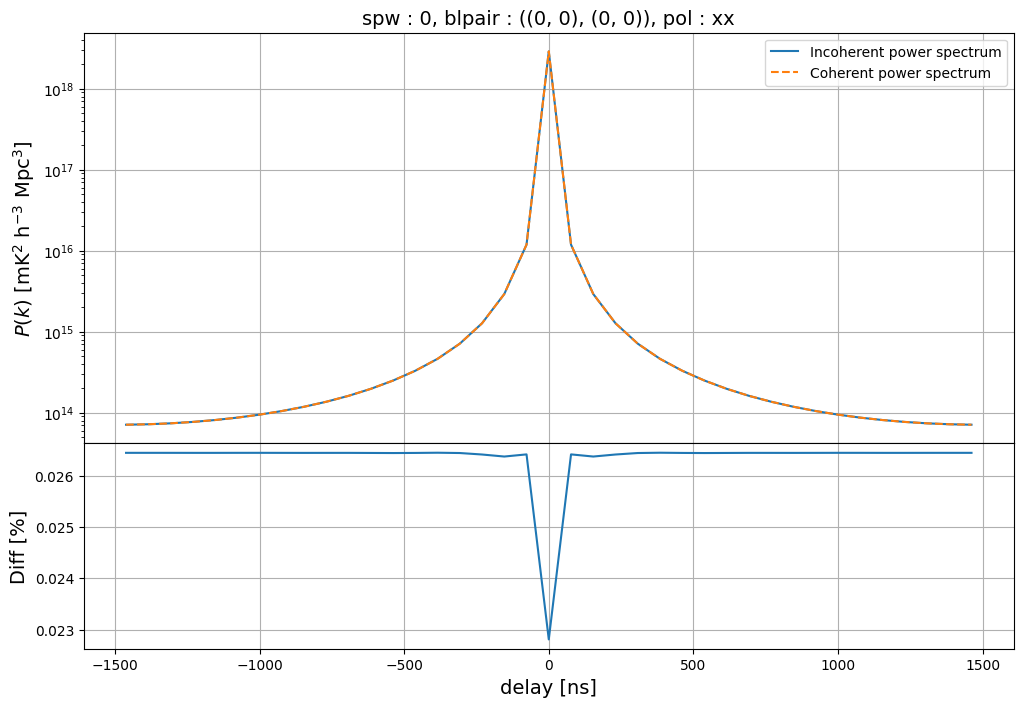

In [51]:
fig, axes = plt.subplots(2,1,figsize=(12,8),gridspec_kw={'hspace':0,'height_ratios':(2,1)})

axes[0].plot(delays, incoherent_ps,label='Incoherent power spectrum')
axes[0].plot(delays, coherent_ps,ls='--',label='Coherent power spectrum')
axes[1].plot(delays, (incoherent_ps-coherent_ps)/coherent_ps*100)

axes[0].set_yscale('log')
axes[1].set_xlabel("delay [ns]", fontsize=14)
axes[0].set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
axes[1].set_ylabel(r"Diff [%]", fontsize=14)
axes[0].set_title("spw : {}, blpair : {}, pol : {}".format(spw,blp2,pol), fontsize=14)
axes[0].legend()
for i in range(len(axes)):
    axes[i].grid()

2. Wedge plot

Text(0.5, 1.0, 'Coherent average')

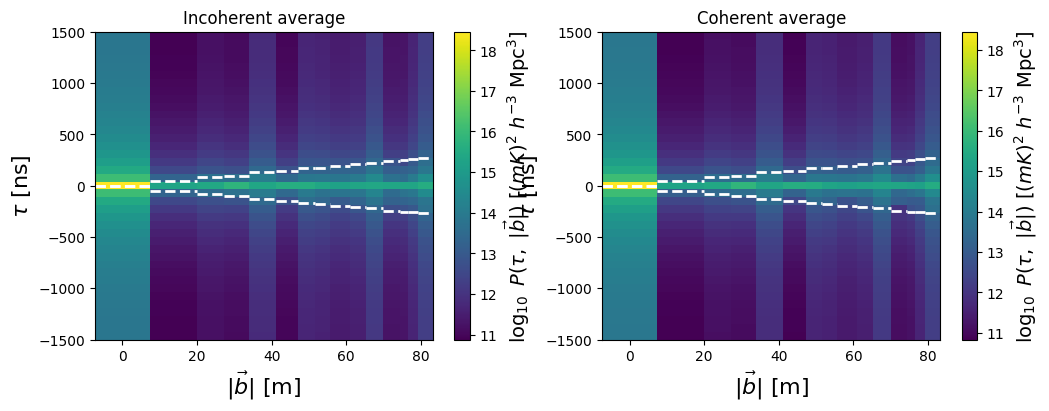

In [52]:
fig,axes= plt.subplots(1,2,figsize=(12,4))
# incoherent average
hp.plot.delay_wedge(uvp3,spw,(pol,pol),delay=True,ax=axes[0], rotate=True, horizon_lines=True, colorbar=True)
axes[0].set_title('Incoherent average')
# Coherent average
hp.plot.delay_wedge(uvp_av,spw,(pol,pol),delay=True,ax=axes[1], rotate=True, horizon_lines=True, colorbar=True)
axes[1].set_title('Coherent average')

Wedge plot of the difference

In [53]:
from matplotlib import colors, cm

invalid escape sequence '\ '
invalid escape sequence '\ '
invalid escape sequence '\ '
The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


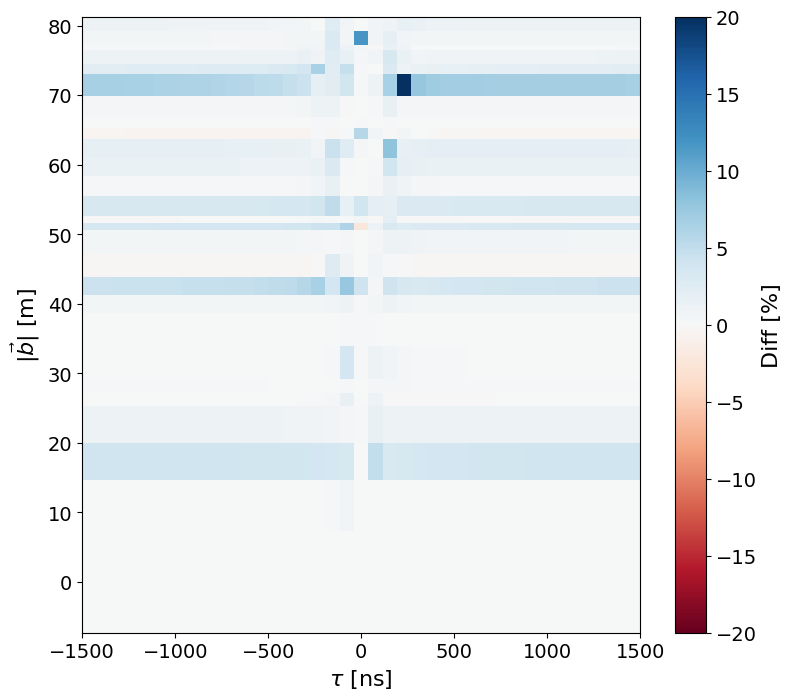

In [54]:
fig, ax = plt.subplots(1,1,figsize=(9,8))

data = np.zeros((2,uvp3.Nblpairs,uvp3.Ndlys))
for i,uvp in enumerate([uvp3,uvp_av]):
    blpairs, blpair_seps = uvp.get_blpairs(), uvp.get_blpair_seps()
    osort = np.argsort(blpair_seps)
    blpairs, blpair_seps = [blpairs[oi] for oi in osort], blpair_seps[osort]
    y_axis = blpair_seps
    data1 = [uvp.get_data((spw, blp, pol)).squeeze() for blp in blpairs]
    data1 = np.abs(np.real(data1))
    data[i,:,:] = np.log10(data1)

x_axis = uvp.get_dlys(spw) * 1e9
xdiff = np.diff(x_axis)
x_edges = np.array([x_axis[0]-xdiff[0]/2.0] + list(x_axis[:-1]+xdiff/2.0) + [x_axis[-1]+xdiff[-1]/2.0])
ydiff = np.diff(y_axis)
y_edges = np.array([y_axis[0]-ydiff[0]/2.0] + list(y_axis[:-1]+ydiff/2.0) + [y_axis[-1]+ydiff[-1]/2.0])
X, Y = np.meshgrid(x_edges, y_edges)
psunits = '(mK)^2\ h^{-3}\  {\rm Mpc}^3'

cmap = cm.get_cmap('RdBu')
norm = colors.Normalize(vmin=-20, vmax=20)
cax = ax.pcolormesh(X, Y, (data[0,:,:]-data[1,:,:])/data[1,:,:]*100, cmap=cmap,norm=norm, edgecolor='none', lw=0.01)
cbar = plt.colorbar(cax)
cbar.set_label('Diff [%]', fontsize=16)
ax.set_xlabel(r"$\tau$ $[{\rm ns}]$", fontsize=16)
ax.set_ylabel(r"$|\vec{b}|$ $[{\rm m}]$", fontsize=16)
ax.tick_params(labelsize=14)
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(14)


## Wedge plot for coherently and incoherently averaged spectra (alternative method)
<a id='subsec:average_alternative'></a>

There are alternative ways of setting up the baselines, doing the coherent averaging, and differencing incoherent/coherent power spectra

### Incoherent averaging of data, and power spectrum generation

In [55]:
# Build as many ant pairs as possible from all redundant groups 

blsp1, blsp2, _, _, _ = hp.utils.calc_blpair_reds(uvd1, uvd2, exclude_auto_bls=True, exclude_permutations=True)

# Power spectrum
uvp0 = ds.pspec(blsp1, blsp2, (0, 1), [('xx', 'xx')], spw_ranges=(0,60), input_data_weight='identity', norm='I', 
                verbose=False)  

Now average the power spectrum by time, and average all the baselines in each redundant group. 
This requires setting up a list of lists, where each sub-list is a list of baselines in each redundant group. `calc_blpair_reds()` doesn't do this (the grouping by redundancy). The list can be explicitly generated. Care must be made to make sure that the same baselines are used 
as for the call to `ds.pspec()`.

Generate the list and average.

In [56]:
baseline_grps, _, _ = uvd.get_redundancies()

blpairs_all = []                         # This will be a list of lists
for group in baseline_grps[1:]:        # Ignore group 1 which is auto correlations 
  baselines_as_antennas = list(map(uvd.baseline_to_antnums, group))
  _, _, blps = hp.utils.construct_blpairs(baselines_as_antennas, exclude_auto_bls=True, exclude_permutations=True)

  if len(group) > 1:             # Including these will later produce an error "blpair 100101103104 not found in data"
    blpairs_all += [blps]     # calc_blpair_reds() has ignored them for bls1, bls2 above, so we must.


# Now can average. 
hp.grouping.average_spectra(uvp0, blpairs_all, time_avg=True)
print("Spectra grid size", uvp0.data_array[0].shape)

Spectra grid size (47, 60, 1)


Plot the power spectrum. Because the number of antennas is small, the power spectrum is not that detailed, but it shows that it can be created.

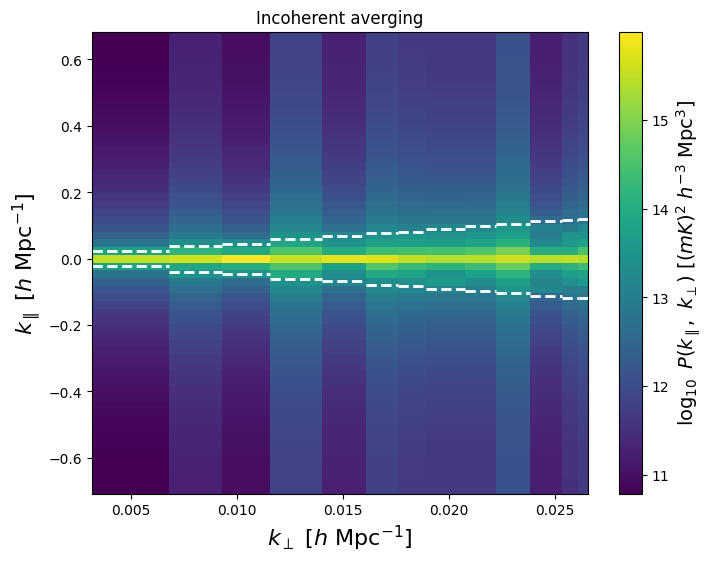

In [57]:
fig = hp.plot.delay_wedge(uvp0, 0, ("xx", "xx"), None, delay=False, rotate=True, horizon_lines=True, colorbar=True, title="Incoherent averging")

### Coherent averaging

To do the coherent averaging, use the `run_red_avg()` function from the H1C pipeline.

In [58]:
import pyuvdata.utils as uvutils
import hera_cal as hc

# Coherent averaging obtained from pspec pipeline

def run_red_avg(datafile, reds, wgt_by_nsample=True, inp_cals=None):

    # setup UVData
    uvd = UVData()
    uvd.read(datafile)
    pols = [uvutils.polnum2str(pol) for pol in uvd.polarization_array]

    # iterate over redundant groups and polarizations
    for pol in pols:
        for blg in reds:
            blg = [ uvd.baseline_to_antnums(bl) for bl in blg ]

            # get data and weight arrays for this pol-blgroup
            d = np.asarray([uvd.get_data(bl + (pol,)) for bl in blg])
            f = np.asarray([(~uvd.get_flags(bl + (pol,))).astype(float) for bl in blg])
            n = np.asarray([uvd.get_nsamples(bl + (pol,)) for bl in blg])
            if 'wgt_by_nsample':
                w = f * n
            else:
                w = f

            # take the weighted average
            wsum = np.sum(w, axis=0).clip(1e-10, np.inf)
            davg = np.sum(d * w, axis=0) / wsum
            navg = np.sum(n, axis=0)
            favg = np.isclose(wsum, 0.0)

            # replace in UVData with first bl of blg
            blinds = uvd.antpair2ind(blg[0])
            polind = pols.index(pol)
            uvd.data_array[blinds, :, polind] = davg
            uvd.flag_array[blinds, :, polind] = favg
            uvd.nsample_array[blinds, :, polind] = navg

    # select out averaged bls
    bls = hp.utils.flatten([[uvd.baseline_to_antnums(blg[0]) + (pol,) for pol in pols] for blg in reds])
    uvd.select(bls=bls)

    return uvd

Run the coherent averaging and setup the new `UVData` object. 

In [59]:
"""
Do the coherent averaging, taking into account redundant groups.
This could be done using uvd_co.compress_by_redundancy(method="average"),
but it does not do exactly the same thing. Using run_red_avg produces
a power spectrum with lower values outside the wedge.
"""

uvd_co = run_red_avg(dfile, baseline_grps)

uvd_co.data_array *= Jy_to_mK[None, :, None]


Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array. Largest imaginary component was 3.1219314517741434e-15, largest imaginary/real ratio was 2.4923919118372765e-18.


\
Setup two data sets from the coherent averaging, which are the same data set, but one is shifted in time. Load these into a `PSpecData` object.

In [60]:
# Create two data sets from this data, shifted in time
uvd1_co = uvd_co.select(times=np.unique(uvd_co.time_array)[:-1:2], inplace=False)
uvd2_co = uvd_co.select(times=np.unique(uvd_co.time_array)[1::2], inplace=False)

# Form power spectrum
ds_int = hp.PSpecData(dsets=[uvd1_co, uvd2_co], beam=uvb)     # Include the beam
ds_int.rephase_to_dset(0)

\
Now we are ready to generate a power spectrum. However, that requires specifying baselines from each data set that can be cross-multipled (actually cross-powered).
There is only 1 baseline in each group, so simply accumulate a list of all the baselines for both data sets. The baseline in one data set will be cross-powered with the same baseline in the other data set. However we must make sure we use the same redundant groups as were used for the incoherent averaged power spectrum.

In [61]:
baseline_groups_co, _, _ = uvd_co.get_redundancies()

bls_all_co = [ uvd.baseline_to_antnums(group[0]) for group in baseline_grps[1:] if len(group) > 1 ]

# Power spectrum
uvp1 = ds_int.pspec(bls_all_co, bls_all_co, (0, 1), [('xx', 'xx')], spw_ranges=(0,60), input_data_weight='identity', 
                norm='I', verbose=False)  

Casting complex values to real discards the imaginary part


\
Now average the power spectrum by time. There is no averaging by baseline because that has already been done, therefore we use `None`
for the baseline pairs in `average_spectra()`.

In [62]:
# Average. The value of None stops baselines being averaged together.
hp.grouping.average_spectra(uvp1, None, time_avg=True)
print("Spectra grid size", uvp1.data_array[0].shape)

Spectra grid size (47, 60, 1)



Plot the delay spectrum.

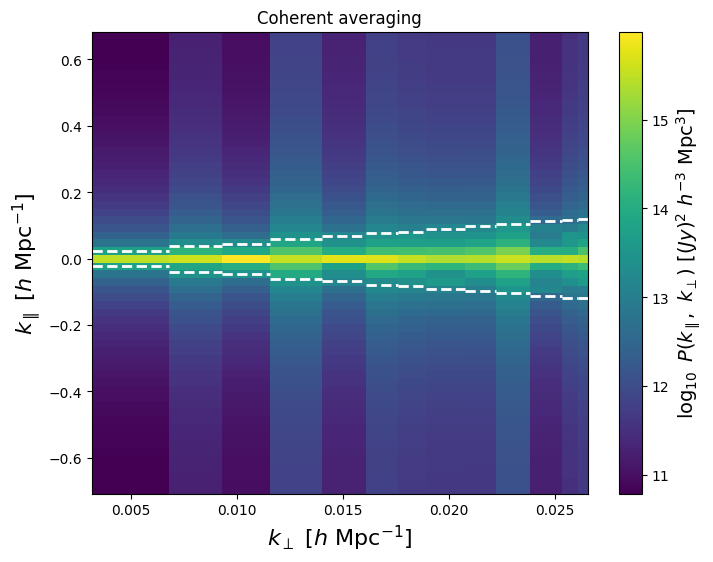

In [63]:
fig = hp.plot.delay_wedge(uvp1, 0, ("xx", "xx"), None, delay=False, rotate=True, horizon_lines=True, 
                          colorbar=True, title="Coherent averaging")

Observe and compare the power spectrum produced by incoherent averaging with the one produced by coherent averaging.
- They are different in their details, but overall much the same.
- The coherent-averaged power spectrum has a lower minimum.


Now we are ready to get the difference between the incoherently and coherently averaged power spectra. First we check that the shapes of the power spectra are the same. Getting the same shape is the reason for all the baseline shenanigans above. 

In [64]:
assert uvp1.data_array[0].shape == uvp0.data_array[0].shape, "Power spectra are not same shape - cannot be subtracted"
uvp_diff = copy.deepcopy(uvp0)
uvp_diff.data_array[0] = uvp1.data_array[0] - uvp0.data_array[0]

Plot the difference

invalid escape sequence '\w'
invalid escape sequence '\w'
invalid escape sequence '\w'
divide by zero encountered in log10


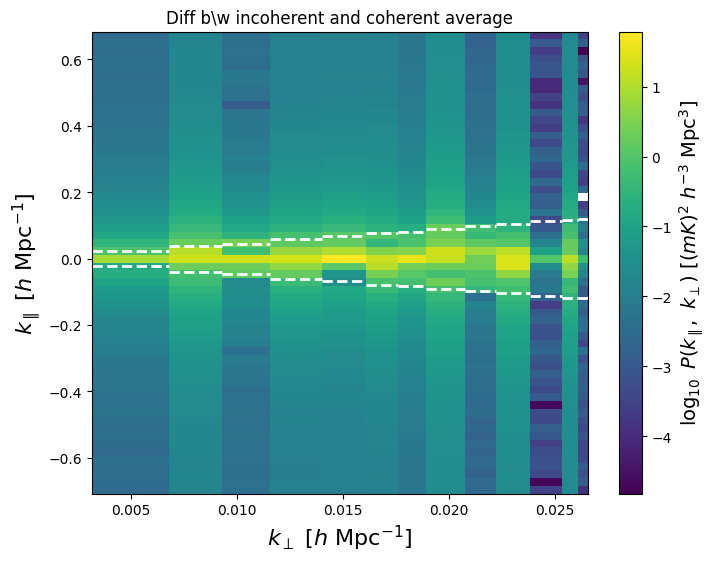

In [65]:
fig = hp.plot.delay_wedge(uvp_diff, 0, ("xx", "xx"), None, delay=False, rotate=True, horizon_lines=True, colorbar=True,
                         title="Diff b\w incoherent and coherent average")

# Error bars
<a id='sec:other'></a>

In this section, we describe different ways to obtain error bars on the computed power spectrum.

## Include thermal noise error bars
<a id='subsec:other_thermal_noise'></a>

The first source of errors considered here is thermal noise.

We start by generating a new, clean data set and computing its averaged power spectrum.

In [66]:
uvd1_Jy = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False)
uvd2_Jy = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False)

In [67]:
# List of beamfile to load. This is a healpix map.
beamfile = os.path.join(DATA_PATH, 'HERA_NF_dipole_power.beamfits')
# instantiate beam and pass cosmology, if not fed, a default Planck cosmology will be assumed
uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)

In [68]:
# calculate all baseline pairs from redundant group
baselines = blp_group[1] 
print(baselines)
baselines1, baselines2, blpairs = hp.utils.construct_blpairs(baselines, 
                                     exclude_auto_bls=True,exclude_permutations=False)
# power spectrum
uvp = ds.pspec(baselines1, baselines2, dsets=(0, 1), pols=[(pol, pol)], spw_ranges=[spw_range], verbose=False, 
               exact_norm=True,store_cov=True)
# time-average
uvp2 = uvp.average_spectra(time_avg=True, inplace=False)

[(0, 1), (1, 2), (3, 4), (4, 5), (5, 6), (7, 8), (8, 9), (9, 10), (10, 11), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (18, 19), (19, 20), (20, 21), (21, 22), (23, 24), (24, 25), (25, 26), (27, 28), (28, 29)]


Producing time-uniform covariance matrices between bandpowers.
Casting complex values to real discards the imaginary part


We use different functions included in the package to simulate noise.

In [69]:
blp = blpairs[0]
spw = 0

#### Noise power spectrum
Tsys = 220.0  # K
uvn1 = hp.testing.noise_sim(uvd1_Jy, Tsys, uvb, seed=0, inplace=False, whiten=True)
uvn2 = hp.testing.noise_sim(uvd1_Jy, Tsys, uvb, seed=1, inplace=False, whiten=True)
dsn = hp.PSpecData([copy.deepcopy(uvn1), copy.deepcopy(uvn2)], wgts=[None, None], beam=uvb)
dsn.dsets[0].vis_units = 'mK'
dsn.dsets[1].vis_units = 'mK'
uvpn = dsn.pspec(baselines1,baselines2, dsets=(0, 1), pols=[(pol, pol)], spw_ranges=[spw_range], verbose=False, 
                 exact_norm=True)
# get standard deviation of real component of delay spectra
P_std = np.std(uvpn.data_array[0].real.squeeze(), axis=0)
# generate theoretical noise spectrum given Tsys
P_N = uvpn.generate_noise_spectra(spw, pol, Tsys,little_h=True)[uvpn.antnums_to_blpair(blp)]

Casting complex values to real discards the imaginary part


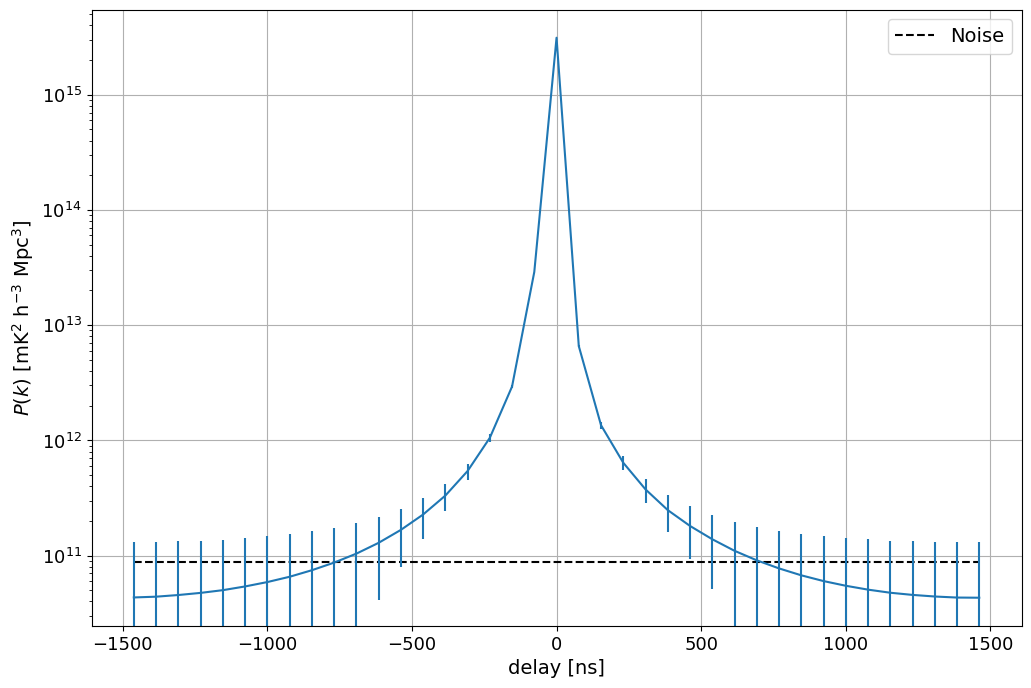

In [70]:
ps = np.abs(np.real(uvp2.get_data((spw, blp, pol))))[0,:]
dlys = uvp.get_dlys(spw)*1e9 #ns

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(dlys,P_N[0,:],lw=1.5,ls='--',color='k',label='Noise')
ax.errorbar(dlys,ps,yerr=P_N[0,:])
ax.set_yscale('log')
ax.grid()
ax.legend(fontsize=14)
ax.set_xlabel("delay [ns]", fontsize=14)
ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.tick_params(labelsize=13)

## Include errors propagated from the input data
<a id='subsec:other_data_errors'></a>

Errors can be estimated from the diagonal of the output covariance matrix. Depending on the covariance model chosen, they will include different things:
- In `empirical` mode, error bars are estimated from the data by averaging the channel-channel covariance of each baseline over time and then applying the appropriate linear transformations to these frequency-domain covariances.
- In `autos`, only the noise-noise correlation terms are included
- In `foreground_dependent`, both noise-noise and signal-noise cross-correlations are included

In [71]:
key = (spw, blp, pol)

#analytical noise
Tsys = 300.0  #K
P_N = uvp.generate_noise_spectra(spw, pol, Tsys,little_h=True)[uvpn.antnums_to_blpair(blp)]

# noise-noise terms only
uvp_nn = ds.pspec(baselines1, baselines2, dsets=(0, 1), pols=[(pol, pol)], spw_ranges=[spw_range], verbose=False, 
               exact_norm=True,store_cov=True, cov_model='autos')

# noise-noise + signal-noise cross-terms
uvp_ns = ds.pspec(baselines1, baselines2, dsets=(0, 1), pols=[(pol, pol)], spw_ranges=[spw_range], verbose=False, 
               exact_norm=True,store_cov=True, cov_model='foreground_dependent')


Text(0, 0.5, '$P(k)\\ \\rm [mK^2\\ h^{-3}\\ Mpc^3]$')

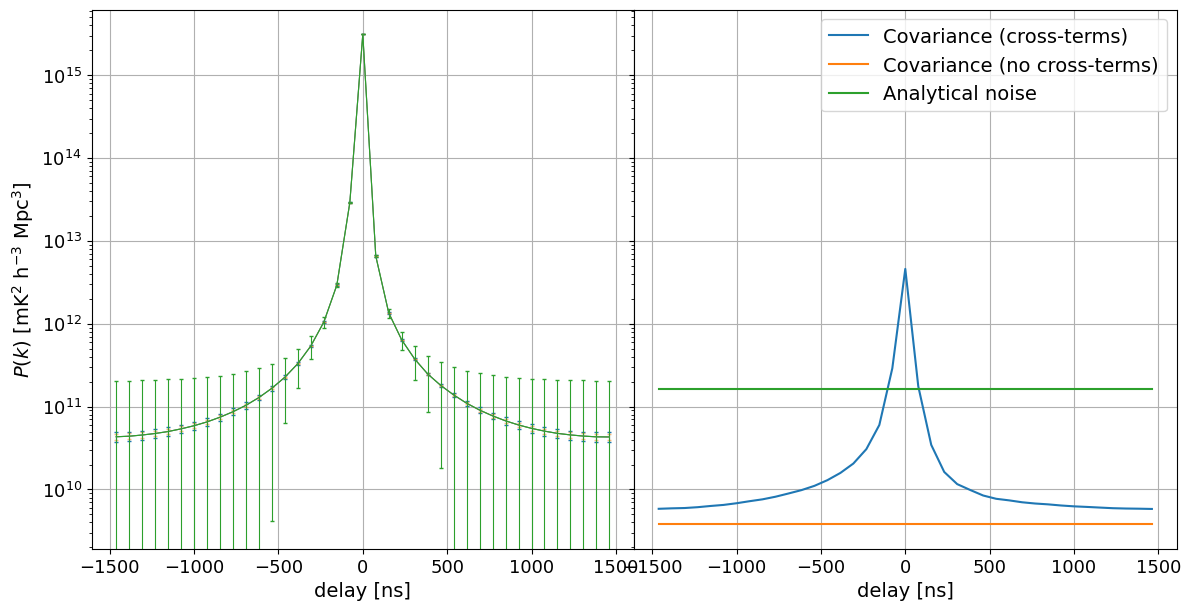

In [72]:
time_index = 0 #we plot only for one time
C_nn = uvp_nn.get_cov(key,component='real')[time_index,:,:] #time-average
err_nn = np.sqrt(np.abs(np.diag(C_nn[:,:])))

C_ns = uvp_ns.get_cov(key,component='real')[time_index,:,:] #time-average
err_ns = np.sqrt(np.abs(np.diag(C_ns[:,:])))

fig, axes = plt.subplots(1,2,figsize=(14,7),sharey=True,gridspec_kw={'wspace':0})
axes[0].errorbar(dlys,ps,yerr=err_ns,label='Errors from covariance (cross-terms)',capsize=1.5,lw=.8)
axes[0].errorbar(dlys,ps,yerr=err_nn,label='Errors from covariance (no cross-terms)',alpha=.5,capsize=1.5,lw=.8)
axes[0].errorbar(dlys,ps,yerr=P_N[0,:],label='Errors from thermal noise',capsize=1.5,lw=.8)

axes[1].plot(dlys,err_ns,label='Covariance (cross-terms)')
axes[1].plot(dlys,err_nn,label='Covariance (no cross-terms)')
axes[1].plot(dlys,P_N[0,:],lw=1.5,label='Analytical noise')

axes[1].legend(fontsize=14)
for i in range(len(axes)):
    axes[i].set_xlabel("delay [ns]", fontsize=14)
    axes[i].tick_params(labelsize=13)
    axes[i].set_yscale('log')
    axes[i].grid()
axes[0].set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)


## Window functions
<a id='subsec:other_wf'></a>

In [73]:
# spherical k-bins
kmax, dk = 2., 0.128
kbin_edges = np.arange(dk*1.5,kmax,step=dk)
kbins = (kbin_edges[1:]+kbin_edges[:-1])/2
nbinsk = kbins.size

#### 1. Approximate window functions

In this sub-section, we show how to output the window functions used to compute the power spectrum. We start by computing a power spectrum:

In [74]:
ds.clear_cache()

In [75]:
# select the data file to load
dfile = os.path.join(DATA_PATH, 'zen.2458116.30448.HH.uvh5')
# Load into UVData objects
uvd = UVData()
uvd.read(dfile)
# List of beamfile to load. This is a healpix map.
beamfile = os.path.join(DATA_PATH, 'HERA_NF_dipole_power.beamfits')
# instantiate beam and pass cosmology, if not fed, a default Planck cosmology will be assumed
uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)
# find conversion factor from Jy to mK
Jy_to_mK = uvb.Jy_to_mK(np.unique(uvd.freq_array), pol=pol)
# reshape to appropriately match a UVData.data_array object and multiply in!
uvd.data_array *= Jy_to_mK[None, :, None]
# slide the time axis of uvd by one integration
uvd1 = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False)
uvd2 = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False)
# Create a new PSpecData object, and don't forget to feed the beam object
ds = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=uvb)
# here we phase all datasets in dsets to the zeroth dataset
ds.rephase_to_dset(0)
# change units of UVData objects
ds.dsets[0].vis_units = 'mK'
ds.dsets[1].vis_units = 'mK'

Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array. Largest imaginary component was 1.400209836965871e-09, largest imaginary/real ratio was 5.690198544794131e-11.


In [76]:
pol = uvutils.polnum2str(uvd.polarization_array[0])
print(pol)

xx


In [77]:
spw_range = (175,334)

In [78]:
# sort baselines in redundant groups
baseline_group, _, lengths = uvd.get_redundancies()

#convert baseline number to antenna numbers tuple
blp_group = []
for group in baseline_group:
    g = []
    for i,bl in enumerate(group):
        g.append(uvd.baseline_to_antnums(bl))
    blp_group.append(g)

# choose one redundancy group for which to compute the power spectrum
baselines = blp_group[1] #first group is auto baselines
print('Baselines considered: %s.' %baselines)
print('They have length %.1f m.' %lengths[1])



baselines = blp_group[1] 
print(baselines)
baselines1, baselines2, blpairs = hp.utils.construct_blpairs(baselines, 
                                     exclude_auto_bls=True,exclude_permutations=False)

Baselines considered: [(23, 24), (24, 25)].
They have length 14.6 m.
[(23, 24), (24, 25)]


In [79]:
uvp = ds.pspec(baselines1, baselines2, dsets=(0,1), pols=[(pol,pol)], spw_ranges=[spw_range], norm='I', verbose=False,
               cov_model='empirical', store_window=True, store_cov=True, taper='blackman-harris')

Producing time-uniform covariance matrices between bandpowers.
Casting complex values to real discards the imaginary part


In [80]:
little_h = 'h^-3' in uvp.norm_units

We extract the normalisation matrix and window functions from the resulting `PSpec` object:

In [81]:
spw=0
key1=(spw,(23, 24, pol))
key2=(spw,(23, 24, pol))
G=ds.get_G(key1,key2,exact_norm=True,pol=pol)
H=ds.get_H(key1,key2,exact_norm=True,pol=pol)
M,W=ds.get_MW(G,H,mode='I')

Text(0, 0.5, '$W(k)$')

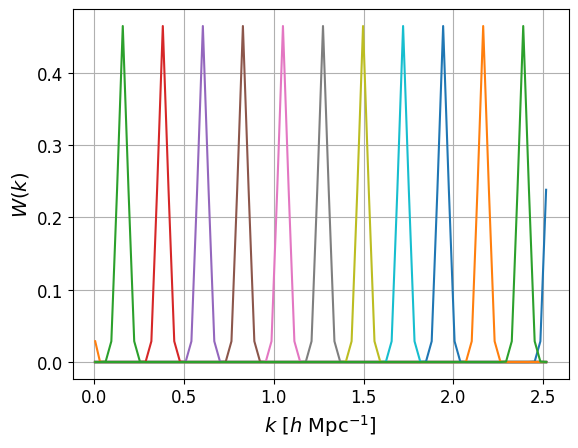

In [82]:
k_perp, k_para = uvp.get_kperps(spw, little_h=little_h), uvp.get_kparas(spw, little_h=little_h) 
k_arr = np.sqrt(np.mean(k_perp)**2+k_para**2)
fig,ax=plt.subplots(1,1)
for i in np.arange(0,W.shape[-1],7):
    ax.plot(k_arr[W.shape[-1]//2:],np.real(W[i,W.shape[-1]//2:]))
ax.grid()
ax.set_xlabel(r"$k\ [h\ {\rm Mpc}^{-1}]$", fontsize=14)
ax.tick_params(labelsize=12)
ax.set_ylabel(r"$W(k)$", fontsize=14)
# ax.set_ylim(0,1)

These window functions will change if the power spectrum is folded or averaged. For example, let us consider spherical average:

In [83]:
spherical_uvp = hp.grouping.spherical_average(uvp,kbins,bin_widths=dk, 
                                              little_h=little_h, time_avg=True)

In [84]:
sphericalW = spherical_uvp.window_function_array[0][0,:,:,0]
print(sphericalW.shape)

(14, 14)


Text(0.5, 1.0, 'Spherical window functions')

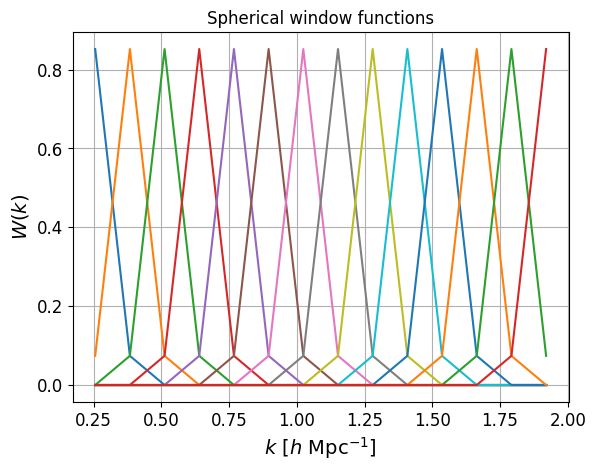

In [85]:
fig,ax=plt.subplots(1,1)
for i in np.arange(kbins.size):
    ax.plot(kbins,sphericalW[i,:])
ax.grid()
ax.set_xlabel(r"$k\ [h~{\rm Mpc}^{-1}]$", fontsize=14)
ax.tick_params(labelsize=12)
ax.set_ylabel(r"$W(k)$", fontsize=14)
ax.set_title('Spherical window functions')
# ax.set_xlim(0.2,1.)

#### 2. Exact window functions

With the `UVWindow` class it is possible to compute more precise window functions, including information about the instrument and a better mapping between measurement space ($b$,$\tau$) and cosmological space ($k_\perp$,$k_\parallel$). Here is how to use it (more details are available in the notebook examples/UVWindow_tutorial.ipynb):

In [86]:
from hera_pspec import UVWindow, FTBeam

The derivation of the window function relies on Fourier transforms performed on the beam of the instrument. The spatial Fourier transforms of the flat-sky-approximated beam have been pre-computed and an example file (called `ftfile` below) is available in `hera_pspec/data/`. This file corresponds to the beam for the `xx` polarisation and a reduced spectral window to save disk space. They can be read by the specific class `FTBeam`.

In [87]:
ftfile = os.path.join(DATA_PATH, 'FT_beam_HERA_dipole_test_xx.hdf5')
ftbeam = FTBeam.from_file(ftfile=ftfile, spw_range=(5,25))

Then the `UVWindow` object is initialised through two `FTBeam` objects corresponding to the two polarisation cross-correlated to obtain the power spectrum you are computing the error bars of.

In [88]:
uvw = UVWindow(ftbeam_obj = (ftbeam, ftbeam),
               taper = uvp.taper,
               cosmo = uvp.cosmo,
               little_h=True,
               verbose=True)

You call also call `UVWindow.from_uvpspec` to initialise the `UVWindow` object directly by reading attributes of an existing `PSPec` object. In this case, the required `FTBeam` object will be computed internally.

The spherical window functions are computed for a given set of baseline lengths (`bl_lens`) and spherical $k$-bins with `astropy` units:

In [89]:
blpair_groups, blpair_lens, _ = uvp.get_red_blpairs()

In [90]:
sph_wf = uvw.get_spherical_wf(kbins * units.h / units.Mpc,
                              kperp_bins=None,kpara_bins=None,
                              bl_lens = blpair_lens)

Computing for blg 1 of 1... 


Max spherical k probed is not included in bins.
Some spherical bins are empty. Add baselines or expand spectral window.


We obtain a 2D array similar to the above, of dimensions (nbinsk, nbinsk).

Text(0, 0.5, '$k$ [$h$~Mpc$^{-1}]$')

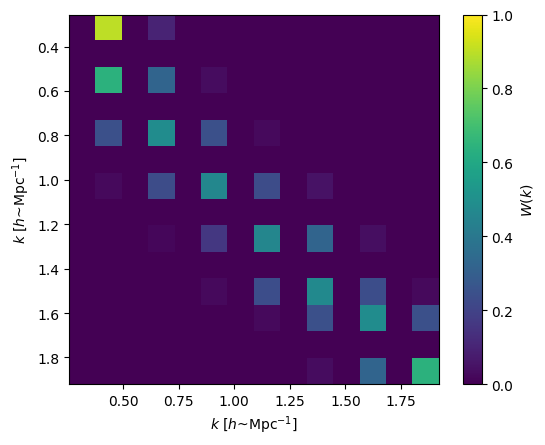

In [91]:
im = plt.imshow(sph_wf,vmin=0,vmax=1,extent=(kbins.min(),kbins.max(),kbins.max(),kbins.min()))
cbar = plt.colorbar(im)
cbar.set_label(r'$W(k)$')
plt.xlabel(r"$k$ [$h$~Mpc$^{-1}]$");plt.ylabel(r"$k$ [$h$~Mpc$^{-1}]$")

Note that the peculiar results are due to the use of a very short spectral window to ease computations.